In [1]:
import torch
import csv
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch_geometric.nn import GATConv
import torch.nn.functional as F
from sklearn import metrics


DATASET = 'cryptobench'
DATA_PATH = f'/home/skrhakv/cryptic-nn/data/{DATASET}'
ESM_EMBEDDINGS_PATH = f'{DATA_PATH}/embeddings'
ADJACENCY_MATRICES_PATH = f'{DATA_PATH}/distance-matrices' 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
DISTANCE_THRESHOLD = 8
CLASS_THRESHOLD = 0.5
def process_sequence_dataset(annotation_path, embeddings_paths):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            sequence = row[4]

            if row[3] == '':
                continue
            
            # load the precomputed embedding
            if id not in Xs:
                for embeddings_path in embeddings_paths:
                    filename = id + '.npy'
                    embedding = np.load(f'{embeddings_path}/{filename}')
                    if id not in Xs:
                        Xs[id] = embedding
                    else:
                        Xs[id] = np.concatenate((Xs[id],embedding), axis = 1)
                    

            # load the annotations denoting whether particular residue is binding or not
            # we use binary annotation: 0=non-binding; 1=binding
            if id not in Ys:
                Ys[id] = np.zeros(embedding.shape[0])
            for (aa, residue_idx) in [(residue[0], int(residue[1:])) for residue in row[3].split(' ')]:
                assert sequence[residue_idx] == aa
                Ys[id][residue_idx] = 1

    return Xs, Ys


def get_adjacency_info(id):
    distance_matrix = np.load(f'{ADJACENCY_MATRICES_PATH}/{id}.npy')

    edge_indices = []

    for iy, ix in np.ndindex(distance_matrix.shape):
        if iy >= ix:
            continue

        if distance_matrix[iy, ix] <= DISTANCE_THRESHOLD:
            edge_indices += [[iy, ix], [ix, iy]]
    
    edge_indices = torch.tensor(edge_indices)
    edge_indices = edge_indices.t().to(torch.long).view(2, -1)
    return edge_indices


def load_dataset(dataset_annotation_filepath):
    Xs, Ys = process_sequence_dataset(dataset_annotation_filepath, [ESM_EMBEDDINGS_PATH])

    protein_list = []
    for key in Xs.keys():
        protein_features = torch.tensor(Xs[key], dtype=torch.float32)
        protein_labels = torch.tensor(Ys[key], dtype=torch.int64)
        protein_edges = get_adjacency_info(key)
        protein = Data(x=protein_features, edge_index=protein_edges, y=protein_labels)
        protein_list.append(protein)
        if protein_edges.shape[1] > 0:
            if protein_edges.max() >= protein_features.size(0):
                print(f'{key}: {protein_edges.max()}, {protein_features.size(0)}')
        
    return protein_list


In [35]:
test_proteins = load_dataset(f'{DATA_PATH}/test.txt')
train_proteins = load_dataset(f'{DATA_PATH}/train.txt')

In [4]:

DROPOUT = 0.3
EMBEDDING_DIM = 2560
HEADS = 16
HIDDEN_CHANNELS = 100
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234567)
        self.dropout0 = nn.Dropout(DROPOUT)

        self.conv1 = GATConv(EMBEDDING_DIM, HIDDEN_CHANNELS, heads=HEADS, dropout=DROPOUT, concat=False)
        # self.dropout00 = nn.Dropout(DROPOUT)

        # self.conv2 = GATConv(HIDDEN_CHANNELS, HIDDEN_CHANNELS, heads=HEADS,
        #                     concat=False, dropout=DROPOUT)

        self.linear1 = nn.Linear(HIDDEN_CHANNELS, HIDDEN_CHANNELS * HEADS)
        self.dropout1 = nn.Dropout(DROPOUT)
        
        self.linear2 = nn.Linear(in_features=HIDDEN_CHANNELS * HEADS, out_features=HIDDEN_CHANNELS * HEADS)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.linear3 = nn.Linear(in_features=HIDDEN_CHANNELS * HEADS, out_features=1)
        self.dropout3 = nn.Dropout(DROPOUT)

        self.relu = nn.LeakyReLU()

    def forward(self, x, edge_index):
        x = self.dropout0(x)
    
        x = self.conv1(x, edge_index)
        # x = self.relu(x)
        # x = self.dropout00(x)

        # x = self.conv2(x, edge_index)

        x = self.relu(x)
        x = self.dropout1(x)
        x = self.linear1(x)

        x = x.relu()
        x = self.dropout2(x)
        x = self.linear2(x)

        x = x.relu()
        x = self.dropout3(x)
        x = self.linear3(x)

        return x

In [7]:

class_weights = torch.tensor([0.5303, 8.7481], device='cuda:0')

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def train(model, optimizer, epochs, train_dataloader, test_dataloader):
    model = model.to(device)


    # compute class weights (because the dataset is heavily imbalanced)
    print(f'Class weights: ', class_weights)
    # BCEWithLogitsLoss - sigmoid is already built-in!
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

    train_losses, test_losses = [], []

    for epoch in range(epochs):
        #
        # TEST
        #
        model.eval()
        with torch.inference_mode():
            for batch_id, data in enumerate(test_dataloader):   
                X_test = data.x.to(device)
                y_test = data.y.to(device).float()
                edges = data.edge_index.to(device)

                test_logits = model(X_test, edges).squeeze()
                test_probs = torch.sigmoid(test_logits)
                test_pred = test_probs > CLASS_THRESHOLD

                test_loss = loss_fn(test_logits,
                                    y_test)
                test_losses.append(test_loss.cpu().detach().numpy())

                y_test_labels = CLASS_THRESHOLD
                # compute metrics on test dataset
                test_acc = accuracy_fn(y_true=y_test,
                                       y_pred=test_pred)
                fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
                roc_auc = metrics.auc(fpr, tpr)

                mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())

        #
        # TRAIN
        #
        batch_losses = []
        for id_batch, data in enumerate(train_dataloader):
            x_batch = data.x.to(device)
            y_batch = data.y.to(device).float()
            edges = data.edge_index.to(device)
            model.train()
            optimizer.zero_grad()
            y_logits = model(x_batch, edges).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = loss_fn(y_logits,
                           y_batch)
            acc = accuracy_fn(y_true=y_batch,
                              y_pred=y_pred)

            loss.backward()

            optimizer.step()

            batch_losses.append(loss.cpu().detach().numpy())

        train_losses.append(sum(batch_losses) / len(batch_losses))
        #if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}, sum: {sum(test_pred)}")
    return train_losses, test_losses



In [38]:
BATCH_SIZE = 8

train_loader = DataLoader(train_proteins, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_proteins, batch_size=len(test_proteins))

model = GCN().to(device)
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.0001)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

train_losses, test_losses = train(model, optimizer, 14, train_loader, test_loader)

# GAT
# Epoch: 37 | Loss: 0.58937, Accuracy: 73.02% | Test loss: 0.68671, AUC: 0.8636530251080131, MCC: 0.28348991842760934, sum: 17158.0

# GAT with two GraphConv layers:
# Epoch: 38 | Loss: 0.57613, Accuracy: 78.00% | Test loss: 0.65644, AUC: 0.8613790084269165, MCC: 0.30587807055399585, sum: 14093.0

# GAT with 64 heads:
# Epoch: 13 | Loss: 0.63359, Accuracy: 80.85% | Test loss: 0.63947, AUC: 0.8634635987324862, MCC: 0.32354901388028406, sum: 12346.0

# GAT without graph convolution layer:
# Epoch: 3 | Loss: 0.67172, Accuracy: 88.80% | Test loss: 0.59212, AUC: 0.877542770203408, MCC: 0.39554805894509715, sum: 7352.0
# Epoch: 60 | Loss: 0.54814, Accuracy: 88.31% | Test loss: 0.59526, AUC: 0.8762555172557703, MCC: 0.3913615526061533, sum: 7686.0

# GAT, distance=3:
# Epoch: 8 | Loss: 0.60385, Accuracy: 79.08% | Test loss: 0.62847, AUC: 0.8777589692266613, MCC: 0.3230871812092425, sum: 13581.0

# GAT, distance=8:
# Epoch: 10 | Loss: 0.74945, Accuracy: 83.07% | Test loss: 0.60357, AUC: 0.8786199743151742, MCC: 0.35114833713417515, sum: 11134.0

# GAT, distance=10:
# Epoch: 5 | Loss: 0.28078, Accuracy: 84.96% | Test loss: 0.60840, AUC: 0.8733979275390964, MCC: 0.3580552333081609, sum: 9835.0



Class weights:  tensor([0.5303, 8.7481], device='cuda:0')
Epoch: 0 | Loss: 0.54719, Accuracy: 5.68% | Test loss: 0.99986, AUC: 0.6104099491375878, MCC: 0.0, sum: 55572.0
Epoch: 1 | Loss: 0.57145, Accuracy: 86.34% | Test loss: 0.69359, AUC: 0.8346930825713041, MCC: 0.29883440352882584, sum: 8053.0
Epoch: 2 | Loss: 0.74873, Accuracy: 85.96% | Test loss: 0.63680, AUC: 0.8611889446793182, MCC: 0.3415133972879305, sum: 8868.0
Epoch: 3 | Loss: 0.52355, Accuracy: 82.06% | Test loss: 0.63627, AUC: 0.8654708857741527, MCC: 0.33282618753049237, sum: 11614.0
Epoch: 4 | Loss: 0.63858, Accuracy: 83.49% | Test loss: 0.62149, AUC: 0.8687977625787462, MCC: 0.34429281521762584, sum: 10737.0
Epoch: 5 | Loss: 0.27946, Accuracy: 83.60% | Test loss: 0.62235, AUC: 0.8690732402253768, MCC: 0.3473196397731512, sum: 10692.0
Epoch: 6 | Loss: 0.42367, Accuracy: 82.83% | Test loss: 0.63192, AUC: 0.8645223160334562, MCC: 0.33606754571389874, sum: 11105.0
Epoch: 7 | Loss: 0.47543, Accuracy: 82.97% | Test loss: 0.64

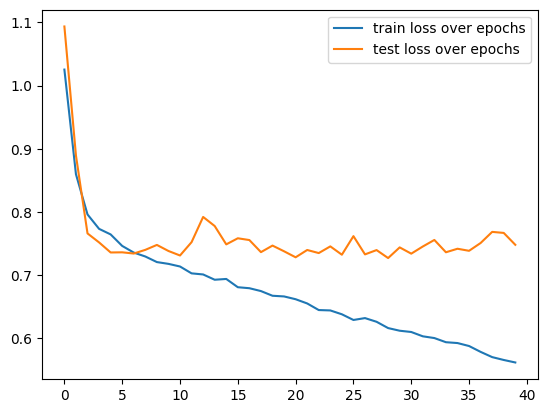

In [22]:
import matplotlib.pyplot as plt

plt.plot(train_losses,label="train loss over epochs")
plt.plot(test_losses,label="test loss over epochs")
plt.legend()
plt.show()

In [17]:
DATASET = 'rigid'
DATA_PATH = f'/home/skrhakv/cryptic-nn/data/{DATASET}'
ESM_EMBEDDINGS_PATH = f'{DATA_PATH}/embeddings'
ADJACENCY_MATRICES_PATH = f'{DATA_PATH}/distance-matrices' 

test_proteins = load_dataset(f'{DATA_PATH}/test.txt')
train_proteins = load_dataset(f'{DATA_PATH}/train.txt')

BATCH_SIZE = 8

train_loader = DataLoader(train_proteins, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_proteins, batch_size=len(test_proteins))


class_weights = torch.tensor([0.5303, 8.7481], device='cuda:0')
model = GCN().to(device)
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.0001)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

train_losses, test_losses = train(model, optimizer, 14, train_loader, test_loader)


Class weights:  tensor([0.5303, 8.7481], device='cuda:0')
Epoch: 0 | Loss: 0.50178, Accuracy: 3.15% | Test loss: 0.86508, AUC: 0.6103346774100286, MCC: 0.0, sum: 39810.0
Epoch: 1 | Loss: 0.51020, Accuracy: 96.85% | Test loss: 0.61468, AUC: 0.7568325045952587, MCC: 0.0, sum: 0.0
Epoch: 2 | Loss: 0.38006, Accuracy: 96.10% | Test loss: 0.56337, AUC: 0.7863131276042965, MCC: 0.13967519643287937, sum: 559.0
Epoch: 3 | Loss: 0.44039, Accuracy: 91.74% | Test loss: 0.52449, AUC: 0.8009612995454469, MCC: 0.24249169564201123, sum: 3141.0
Epoch: 4 | Loss: 0.26349, Accuracy: 91.01% | Test loss: 0.51685, AUC: 0.8059313531289888, MCC: 0.26322294428542004, sum: 3601.0
Epoch: 5 | Loss: 0.46220, Accuracy: 91.10% | Test loss: 0.50779, AUC: 0.8076607497995202, MCC: 0.26129188931180686, sum: 3548.0
Epoch: 6 | Loss: 0.46142, Accuracy: 90.22% | Test loss: 0.51308, AUC: 0.8078621382730946, MCC: 0.26090856659019823, sum: 3978.0
Epoch: 7 | Loss: 0.34509, Accuracy: 91.13% | Test loss: 0.51386, AUC: 0.8076600889

In [ ]:
CLASS_THRESHOLD = 0.5
def process_sequence_dataset(annotation_path, embeddings_paths):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            sequence = row[4]

            if row[3] == '':
                continue
            
            # load the precomputed embedding
            if id not in Xs:
                for embeddings_path in embeddings_paths:
                    filename = id + '.npy'
                    embedding = np.load(f'{embeddings_path}/{filename}')
                    if id not in Xs:
                        Xs[id] = embedding
                    else:
                        Xs[id] = np.concatenate((Xs[id],embedding), axis = 1)
                    

            # load the annotations denoting whether particular residue is binding or not
            # we use binary annotation: 0=non-binding; 1=binding
            if id not in Ys:
                Ys[id] = np.zeros(embedding.shape[0])
            for (aa, residue_idx) in [(residue[0], int(residue[1:])) for residue in row[3].split(' ')]:
                residue_idx -= 1
                assert sequence[residue_idx] == aa
                Ys[id][residue_idx] = 1

    return Xs, Ys

DATASET = 'Yu_DNA'
DATA_PATH = f'/home/skrhakv/cryptic-nn/data/{DATASET}'
ESM_EMBEDDINGS_PATH = f'{DATA_PATH}/embeddings'
ADJACENCY_MATRICES_PATH = f'{DATA_PATH}/distance-matrices' 

test_proteins = load_dataset(f'{DATA_PATH}/test.txt')
train_proteins = load_dataset(f'{DATA_PATH}/train.txt')

BATCH_SIZE = 8

train_loader = DataLoader(train_proteins, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_proteins, batch_size=len(test_proteins))


class_weights = torch.tensor([0.5449, 6.0737], device='cuda:0')
model = GCN().to(device)
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.0001)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

train_losses, test_losses = train(model, optimizer, 14, train_loader, test_loader)



Class weights:  tensor([0.5449, 6.0737], device='cuda:0')
Epoch: 0 | Loss: 0.80985, Accuracy: 94.30% | Test loss: 0.89567, AUC: 0.5351044079300133, MCC: 0.0, sum: 0
Epoch: 1 | Loss: 0.55472, Accuracy: 94.30% | Test loss: 0.73933, AUC: 0.8253593363770061, MCC: 0.0, sum: 0
Epoch: 2 | Loss: 0.46063, Accuracy: 94.30% | Test loss: 0.48169, AUC: 0.8963478778281349, MCC: 0.0, sum: 0
Epoch: 3 | Loss: 0.72073, Accuracy: 94.30% | Test loss: 0.43056, AUC: 0.9093715792055749, MCC: 0.0, sum: 0
Epoch: 4 | Loss: 0.55105, Accuracy: 94.30% | Test loss: 0.42364, AUC: 0.9152872243618411, MCC: 0.021135656725792852, sum: 2
Epoch: 5 | Loss: 0.32396, Accuracy: 94.34% | Test loss: 0.41789, AUC: 0.9174722220368133, MCC: 0.09393626462390657, sum: 24
Epoch: 6 | Loss: 0.48834, Accuracy: 94.43% | Test loss: 0.40556, AUC: 0.9202338182518017, MCC: 0.16593309534193917, sum: 67
Epoch: 7 | Loss: 0.52403, Accuracy: 94.52% | Test loss: 0.41417, AUC: 0.9222931782128212, MCC: 0.2099017439092629, sum: 98
Epoch: 8 | Loss: 0.

KeyboardInterrupt: 